In [1]:
import numpy as np
from skimage import io, color
import pylab as pl
from skimage.filters import gabor_kernel
from scipy.ndimage.filters import gaussian_filter
import pylab as pl
import math
from scipy.signal import convolve2d
import matplotlib as m
from scipy.signal import savgol_filter
from scipy.cluster.vq import vq, kmeans2, whiten
from scipy.sparse import diags
from scipy.sparse import linalg
%matplotlib inline

(241, 161, 3)


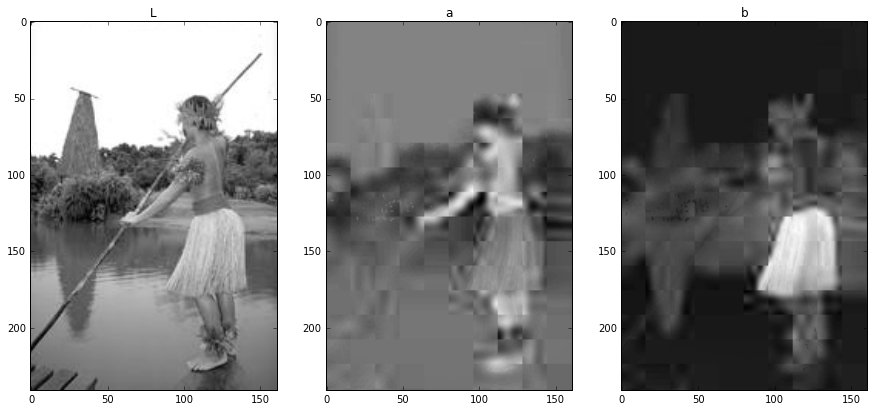

In [2]:
#1. load an image and convert it to the LAB color space
rgb = io.imread('try.jpg')
lab = color.rgb2lab(rgb)
fig, ax = pl.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(lab[:,:,0], cmap='gray')
ax[1].imshow(lab[:,:,1], cmap='gray')
ax[2].imshow(lab[:,:,2], cmap='gray')
ax[0].set_title("L")
ax[1].set_title("a")
ax[2].set_title("b")
print lab.shape

8 oriented even- and odd-symmetric Gaussian derivative filters


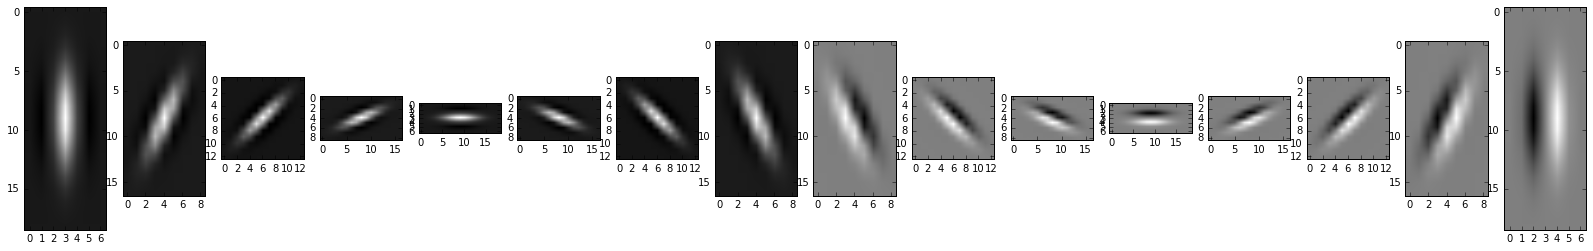

In [30]:
#2. Form a texture channel:
#    a) convert an image to gray scale
#    b) convolve the gray scale imege with gabor_kernels ()
#    c) clusterize via kmeans
#    d) assign corresponding textone id to each pixel 

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


def gabor_kernels(sigma, frequency ):
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 8):
        kernel = gabor_kernel(frequency, theta ,sigma, sigma)
        filters.append(kernel)
    return filters

sigma = 1.
frequency = 0.2

picr,picc, _ =rgb.shape
gray = rgb2gray(rgb)
filters = gabor_kernels(sigma,frequency)

labt = []
for kernel in filters:
    labt.append( convolve2d(gray, np.real(kernel), mode='same', boundary  ='wrap'))

for kernel in filters:
    labt.append(convolve2d(gray, np.imag(kernel), mode='same', boundary  ='wrap'))
    
    
#ceneter filter: difference of gaussians
labt.append(gaussian_filter(gray, sigma) - gaussian_filter(gray, sigma/math.sqrt(2))) 
labt = np.asarray(labt)


fig, ax = pl.subplots(1, 16, figsize=(28, 28))
i = 0 
for pic in filters:
    ax[i].imshow(pic.real,cmap = 'gray')
    ax[15-i].imshow(pic.imag,cmap = 'gray')
    i+=1
print '8 oriented even- and odd-symmetric Gaussian derivative filters'

In [31]:
labt.shape

(17, 241, 161)

In [4]:
# clustering 
labt = labt.reshape(17,-1,order = 'F')
labt = whiten(labt.T)
c, Textons = kmeans2(labt, 32, minit='points')
texture = Textons.T.reshape((picr,picc,1), order ='f')
image = np.concatenate((lab,texture), axis=2)

/Library/Python/2.7/site-packages/scipy/cluster/vq.py:659: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


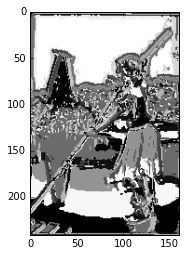

In [5]:
pl.imshow(texture.reshape(picr,-1),cmap = 'gray')

In [6]:
image[:,:,3] = image[:,:,3]/abs(image[:,:,3]).max()

In [7]:
def make_f(r,theta):
    d = 2
    ra = r
    rb = ra / 4
    rb = max(1.5, rb)
    ira2 = 1 / ra**2
    irb2 = 1 / rb**2
    wr = int(max(ra, rb))
    wd = 2*wr+1
    sint = np.sin(theta)
    cost = np.cos(theta)
    
    #1. compute linear filters for coefficients
    # (a) compute inverse of least-squares problem matrix
    filt = np.zeros((wd,wd,d+1))
    xx = np.zeros((2*d+1))
    for u in range (-wr, wr):
        for v in range (-wr, wr):
            ai = -u*sint + v*cost # distance along major axis
            bi = u*cost + v*sint # distance along minor axis
            if ai*ai*ira2 + bi*bi*irb2 > 1:
                    continue
            else:
                c = np.concatenate((np.array([1]).reshape(1,1),ai+np.zeros((2*d,1))))
                xx = xx + np.cumprod(c)
    A = np.zeros((d+1,d+1))
    for i in range(d+1):
        A[:,i] = xx[i:i+d+1]
        
    # (b) solve least-squares problem for delta function at each pixel
    for u  in range (-wr, wr):
        for v  in range (-wr, wr):
            ai = -u*sint + v*cost # distance along major axis
            bi = u*cost + v*sint # distance along minor axis
            if (ai*ai*ira2 + bi*bi*irb2) > 1:
                continue
            else:
                c = np.concatenate((np.array([1]).reshape(1,1),ai+np.zeros((d,1))))
                yy = np.cumprod(c)
                filt[v+wr+1,u+wr+1,:] = np.linalg.solve(A,yy)
    return filt


def fitparab(layer,filt):
    window_length = 11
    conv = convolve2d(layer,filt[:,:,2], mode = 'same', boundary  ='wrap')
    G = savgol_filter(conv, window_length, polyorder = 2, axis = 0, mode='wrap')
    G = savgol_filter(G, window_length, polyorder = 2, axis = 1, mode='wrap')
    return G


/Library/Python/2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


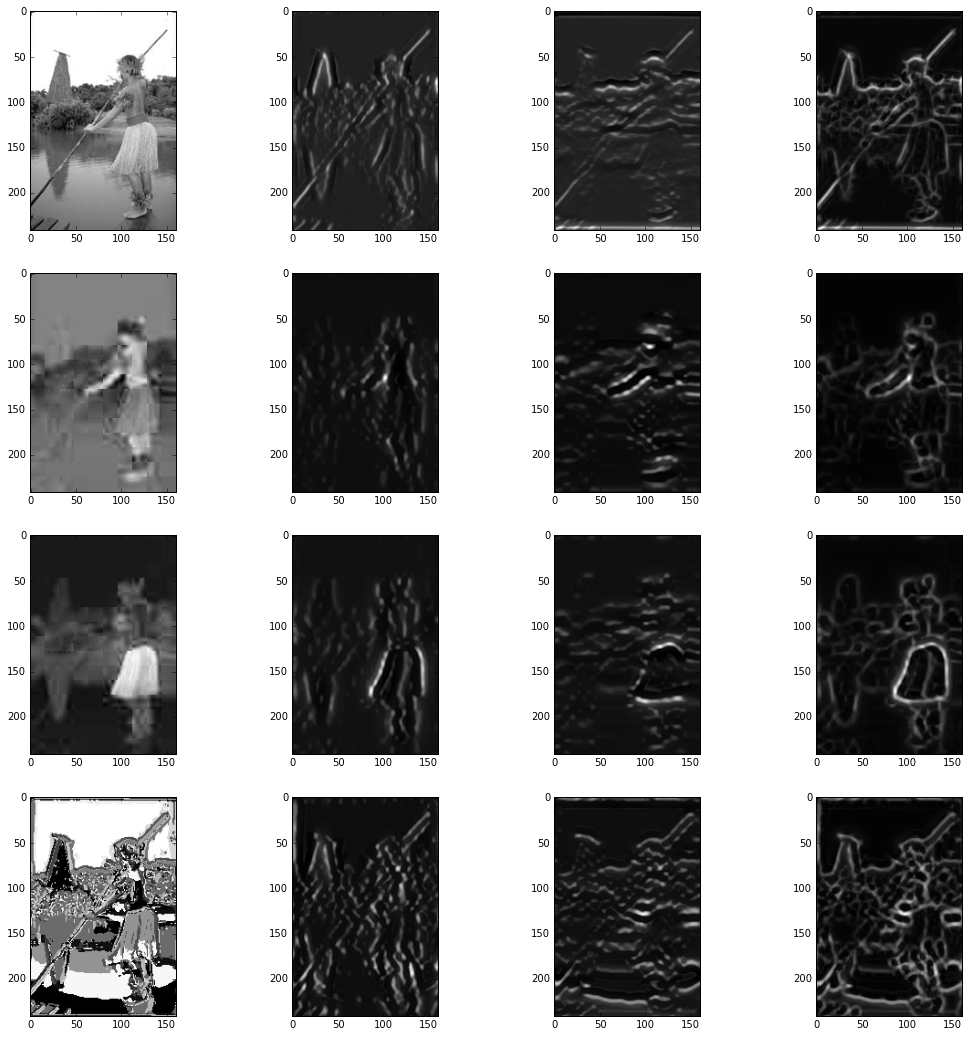

In [8]:
matrix = []

channel_1 = image[:,:,0]
channel_2 = image[:,:,1]
channel_3 = image[:,:,2]
channel_4 = image[:,:,3]
    
for th in np.arange(0, np.pi, np.pi / 8):
    
    f_3 = make_f(3,th) 
    f_5 = make_f(5,th)
    f_10 = make_f(10,th)
    f_20 = make_f(20,th)
    
    
    matrix.append(fitparab(channel_1, f_3))
    matrix.append(fitparab(channel_1,f_5))
    matrix.append(fitparab(channel_1,f_10))
    
    matrix.append(fitparab(channel_2,f_5))
    matrix.append(fitparab(channel_2,f_10))
    matrix.append(fitparab(channel_2,f_20))
    
    matrix.append(fitparab(channel_3,f_5))
    matrix.append(fitparab(channel_3,f_10))
    matrix.append(fitparab(channel_3,f_20))
    

    matrix.append(fitparab(channel_4,f_5))
    matrix.append(fitparab(channel_4,f_10))
    matrix.append(fitparab(channel_4,f_20))
    
        
matrix = np.asarray(matrix)


fig, ax = pl.subplots(4, 4, figsize=(18, 18))
ax[0][0].imshow(channel_1,cmap = 'gray')
ax[1][0].imshow(channel_2,cmap = 'gray')
ax[2][0].imshow(channel_3,cmap = 'gray')
ax[3][0].imshow(channel_4,cmap = 'gray')

#th = np.pi/2            
ax[0][2].imshow(np.array(matrix[:3,:,:]).max(0),cmap = 'gray')
ax[1][2].imshow(np.array(matrix[3:6,:,:]).max(0),cmap = 'gray')
ax[2][2].imshow(np.array(matrix[6:9,:,:]).max(0),cmap = 'gray')
ax[3][2].imshow(np.array(matrix[9:12,:,:]).max(0),cmap = 'gray')
        
#th = 0
ax[0][1].imshow(np.array(matrix[48:51,:,:]).max(0),cmap = 'gray')
ax[1][1].imshow(np.array(matrix[51:54,:,:]).max(0),cmap = 'gray')
ax[2][1].imshow(np.array(matrix[54:57,:,:]).max(0),cmap = 'gray')
ax[3][1].imshow(np.array(matrix[57:60,:,:]).max(0),cmap = 'gray')

#max for each layer

ind_1 = []
for i in range(0, 96, 12):
    ind_1.append([i, i+1, i+2])
ind_1 = np.asarray(ind_1).reshape(-1)

ind_2 = []
for i in range(3, 96, 12):
    ind_2.append([i, i+1, i+2])
ind_2 = np.asarray(ind_2).reshape(-1)

ind_3 = []
for i in range(6, 96, 12):
    ind_3.append([i, i+1, i+2])
ind_3 = np.asarray(ind_3).reshape(-1)

ind_4 = []
for i in range(9, 96, 12):
    ind_4.append([i, i+1, i+2])
ind_4 = np.asarray(ind_4).reshape(-1)

ax[0][3].imshow(np.array(matrix[ind_1,:,:]).max(0),cmap = 'gray')           
ax[1][3].imshow(np.array(matrix[ind_2,:,:]).max(0),cmap = 'gray')       
ax[2][3].imshow(np.array(matrix[ind_3,:,:]).max(0),cmap = 'gray')            
ax[3][3].imshow(np.array(matrix[ind_4,:,:]).max(0),cmap = 'gray')

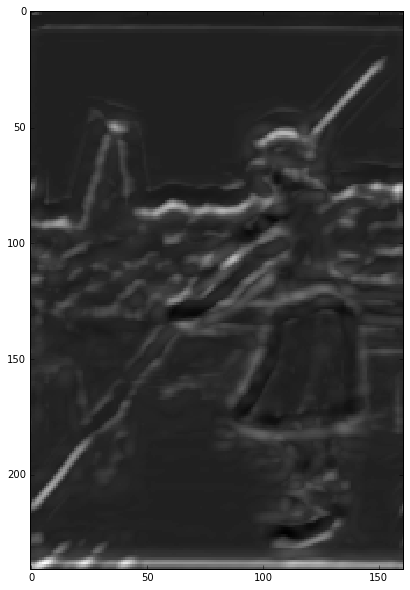

In [9]:
#w = [0.0146,0.0145,0.0163,0.0210,0.0243,0.0287,0.0166,0.0185,0.0204,0.0101,0.0111,0.0141]
w = [0.0245,0.0220,0.0233,0,0,0,0,0,0,0.0208,0.0210,0.0229]

mpb_oriented = np.zeros((8,picr,picc))


for i in xrange(12):
    mpb_oriented += w[i]*matrix[8*i:8*i+8,:,:]
    
mpb = np.amax(mpb_oriented, axis=0) 
pl.figure(figsize =(10,10))
pl.imshow(mpb,cmap = 'gray', interpolation="nearest")
pl.savefig('mpb.png')

In [10]:
mpb[mpb<0.01] = 0
norm_mpb = mpb/ mpb.max()

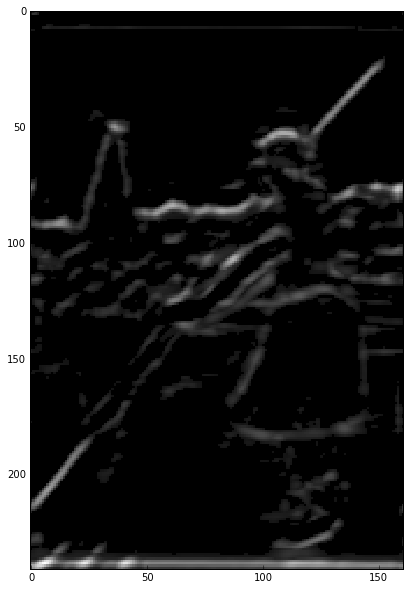

In [11]:
#mpb after thresholding
pl.figure(figsize =(10,10))
pl.imshow(norm_mpb,cmap = 'gray', interpolation="nearest")

In [12]:
from scipy.sparse import coo_matrix 
def bresenham(i1,j1,i2,j2):
    result = []
    i = float(i1)
    j = float(j1)
    if j2 == j1:
        di = np.sign(i2-i1)
        dj = 0
    else:
        di = float(i2-i1)/abs(j2-j1)
        if abs(di)>1:
            di = np.sign(di)
        if di == 0:
            dj = np.sign(j2-j1)
        else:
            dj = float(j2-j1)/abs(i2-i1)
            if abs(dj)>1:
                dj = np.sign(dj)
    for it in xrange(max(abs(i2-i1),abs(j2-j1))+1):
        result.append( (round(i),round(j)) )
        i += di
        j += dj
    return result
            
def W_for_cell(matrix, i, j,data, row, col):
    n,m = matrix.shape
    i_s,i_e = max(i-5,0),min(i+6,n)
    j_s,j_e = max(j-5,0),min(j+6,m)
    for ii in xrange(i_s,i_e):
        for jj in xrange(j_s,j_e):
            line = []
            coords = bresenham(ii,jj,i,j)
            for k in coords:
                line.append(matrix[k])
            max_v = max(line) 
            data.append( - np.exp(max_v/0.1))
            #data.append(1 - np.exp(-max_v/0.1))
            #data.append(max_v)
            row.append(j+i*m)
            col.append(ii*m+jj)

            
            
            
def make_W(matrix):
    n = matrix.shape[0]
    m = matrix.shape[1]
    data,row,col = [],[],[]
    for i in xrange(n):
        for j in xrange(m):
            W_for_cell(matrix, i, j,data,row,col)
    return coo_matrix((data, (row, col)), shape=(n*m, n*m)).tocsc()

In [13]:
w = make_W(norm_mpb)
print w.shape , w.nnz

/Library/Python/2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(38801, 38801) 4563161


### Check, that W is formed correctly: line i*n+j is the result of placing window at pixel i,j and computing for every point withing the window -exp(MAX), where  MAX is the maximum element along the bresenham line between pixel (i,j) and the current point.

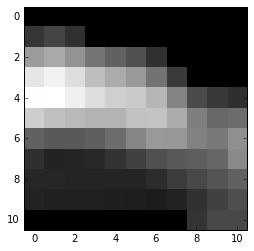

In [14]:
i = 85
j = 65
pl.imshow(mpb[i-5:i+6,j-5:j+6], interpolation='nearest', cmap='gray')

/Library/Python/2.7/site-packages/ipykernel/__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


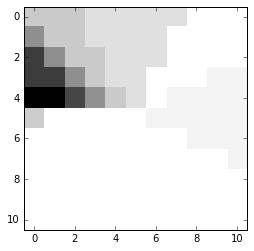

In [15]:
data,row,col = [],[],[]
W_for_cell(mpb, i, j,data,row,col)
s = np.asarray(data).reshape(11,-1)
pl.imshow(s.astype(np.float), interpolation='nearest', cmap='gray')

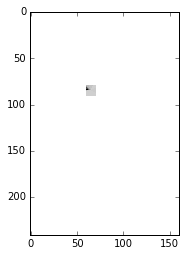

In [16]:
ar = w.toarray()
r = set(row).pop()
pl.imshow(ar[:,r].reshape(picr,-1), interpolation='nearest', cmap='gray')

In [17]:
#check that w doesn't contain empty lines
em = []
ar = w.toarray()
for i in xrange(9801):
    c = ar[i,:].nonzero()[0]
    if c.size == 0:
        em.append(i)
print len(em)

0


In [18]:
diagonal = np.array(w.sum(axis=0)) 
D = diags(diagonal, [0]) 
A = D - w
lm, vecs = linalg.eigs(A,16, M = D)

/Library/Python/2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:243: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


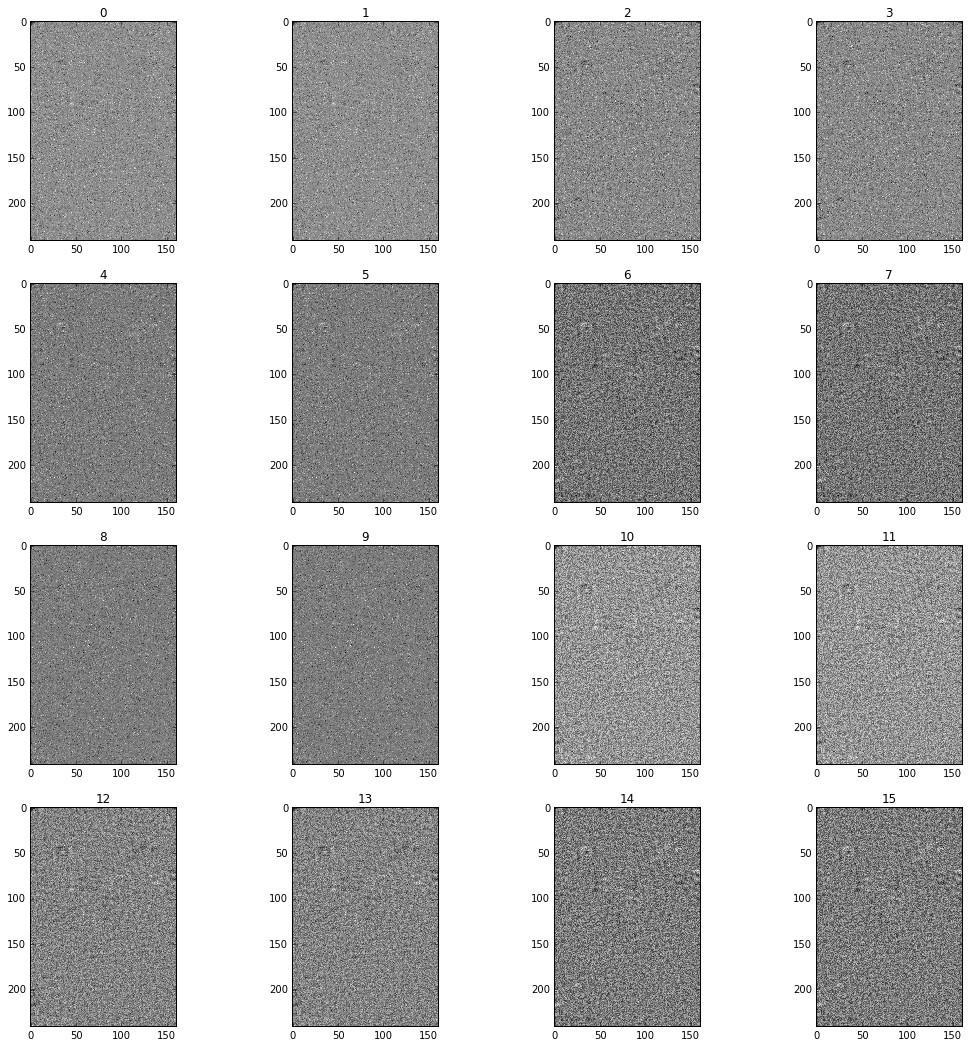

In [20]:
from scipy.misc import toimage
fig, ax = pl.subplots(4, 4, figsize=(18, 18))
for i in xrange(16):
    pic = vecs[:, i]
    pic = pic.reshape(picr,-1)
    pic = toimage(pic.real)
    ax[i//4][i%4].imshow(pic, interpolation='nearest', cmap='gray')
    ax[i//4][i%4].set_title(i)

In [42]:
oriented_gaussian.shape

(8, 23, 23, 3)

In [70]:
oriented_gaussian = []
for th in np.arange(0, np.pi, np.pi / 8):
    oriented_gaussian.append(make_f(11,th))
oriented_gaussian = np.asarray(oriented_gaussian)

ww,vv = vecs.shape
spb_oriented = np.zeros((8,vv,ww))
i=0
for f in oriented_gaussian:
    cons = math.sqrt(1./abs(lm[v]))
    pic = (cons*vecs[:,v]).reshape(picr,-1)
    spb_oriented[i,v,:] = convolve2d(pic, f[:,:,2], mode='same', boundary  ='wrap').reshape(-1) 
    i+=1

/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: ComplexWarning: Casting complex values to real discards the imaginary part


In [71]:
spb_oriented.mean(), spb_oriented.max(), spb_oriented.min()

(-1.060341287048789e-41, 4.8751264827030294e-23, -6.2546749887681938e-23)

In [72]:
spb_oriented[spb_oriented<2e-23] = 0
spb_oriented=  spb_oriented/ spb_oriented.max()
spb = spb_oriented.sum(axis=1)
spb = np.amax(spb,axis =0)

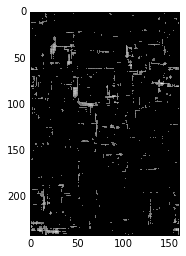

In [73]:
pl.imshow(spb.astype(np.float).reshape(picr,-1), interpolation='nearest', cmap='gray')
pl.savefig('spb.png')

In [74]:
#weight = [0.,0.,0.0039,0.0050,0.0058,0.0069,0.0040,0.0044,0.0049,0.0024,0.0027,0.0170,0.0074] #1
spb = spb.reshape(picr,-1)
weight = [0.,0.,0.0054,0.,0.,0.,0.,0.,0.,0.0048,0.0049,0.0264,0.0050] #2
result_oriented = np.zeros((8,picr,picc))
for i in xrange(12):
    result_oriented += weight[i]*matrix[8*i:8*i+8,:,:]


result_oriented+= spb*weight[12]

In [75]:
result_oriented.max(),result_oriented.mean(), result_oriented.min()

(0.030061844169399839, 0.00015457498044832489, -0.037763819000402321)

In [76]:
result_oriented[result_oriented<0] = 0
result_oriented = result_oriented/result_oriented.max()
result = np.amax(result_oriented,axis=0)

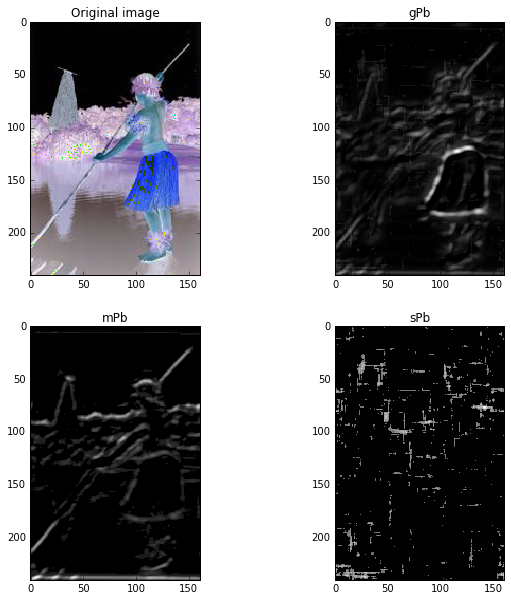

In [77]:
fig, ax = pl.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb.astype(np.float), interpolation='nearest', cmap = 'gray')
ax[0][0].set_title('Original image')
ax[1][0].imshow(mpb, interpolation='nearest', cmap='gray')
ax[1][0].set_title('mPb')
ax[0][1].imshow(result.astype(np.float), interpolation='nearest', cmap='gray')
ax[0][1].set_title('gPb')
ax[1][1].imshow(spb, interpolation='nearest', cmap='gray')
ax[1][1].set_title('sPb')
fig.savefig('res.png')